In [37]:
# -*- coding: utf-8 -*-
"""
Created on Wed Mar 10 09:08:32 2021

@author: phmeay
"""

'\nCreated on Wed Mar 10 09:08:32 2021\n\n@author: phmeay\n'

In [38]:
# Libraries 

In [39]:
import numpy as np
from scipy import signal
import  pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import butter, lfilter, freqz
import mne
from scipy import ndimage
#import mplcursors
import scipy.signal
from datetime import datetime
%matplotlib inline

In [40]:
# reading edf file 

In [41]:

file = "20210224104858_test1.edf"
data = mne.io.read_raw_edf(file)
raw_data = data.get_data()
info = data.info
channels = data.ch_names


Extracting EDF parameters from C:\Users\phmeay\Desktop\Work files\Test 2021-02-26\20210224104858_test1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


reading csv file is done using pandas, this file edited from matlab due to some problems. at some point delimiters are not same, two space between column 1 and column 2. the rest have only 1 space between. 
second problem is that float samples are decimated by comma instead dot,(for example samples look 4,1 instead 4.1. The problem's been solved by using following code snippet

In [42]:
df = pd.read_csv('myData.csv', delimiter=' ')

# columns decimated by comma 
df2 = df.loc[:,'ax_g_':'T___']

# decimations converted from comma to dot
df2 = df2.apply(lambda x: x.str.replace(',','.'))

#converting from pandas to numpy 
dataframe = df2.to_numpy().astype('float64') 

In [43]:
# C3,C1, Cz,C2,C4, and Oz data extracted from raw_data. raw data contains all signals in EDF file

In [44]:
EEG_signals = raw_data[1:8,:]


In [45]:
# time data extracted from data frame

In [46]:
time = df.loc[:,'Time_s_']


In [47]:
# convert the time stamp into UNIX time number (including milliseconds)

In [48]:
date = '24.02.2021'
unixfile= []
for i in range(len(time)):
    time_stamp = str(date)+' ' + time[i]
    dt_obj = datetime.strptime(time_stamp,
                               '%d.%m.%Y %H.%M.%S.%f')
    millisec = dt_obj.timestamp() * 1000
    unixfile.append(millisec)
unixfile = np.array(unixfile)

In [49]:
# wx data extracted from data frame to detect the start of the movement in accelerometer data

In [50]:
n = len(dataframe) % 4
wx = dataframe[n:,3]

In [51]:
# defining zero crossing point where samples change the sign from + to -. This is where we can detect the start of 
# the movement in accelerometer data

In [52]:

def crossings_zero_pos2neg(data):
    pos = data > 0
    return (pos[:-1] & ~pos[1:]).nonzero()[0]

In [53]:
# Removing all samples that are smaller than -50 and bigger that 50.
# this helps us to remove noises in wx data. due to these noises 
# the above function detect these noises as zero crossing points
# I will also try median filtering

In [54]:
k = np.where( (wx >-50) & (wx <50), 0, wx) 
k = np.where(k==0, 0.001, k)
c = crossings_zero_pos2neg(k)

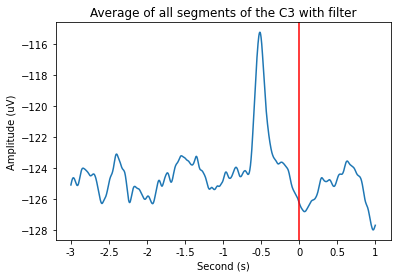

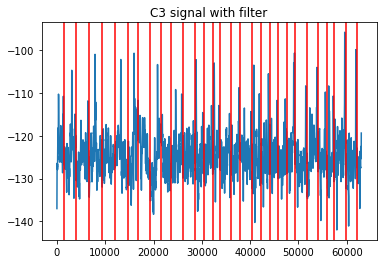

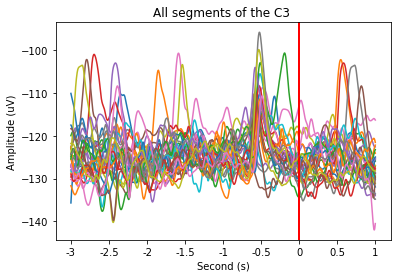

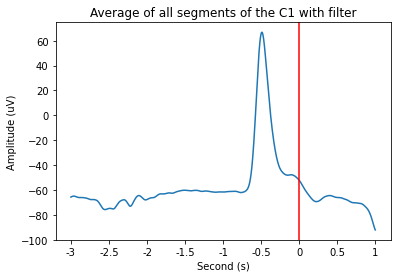

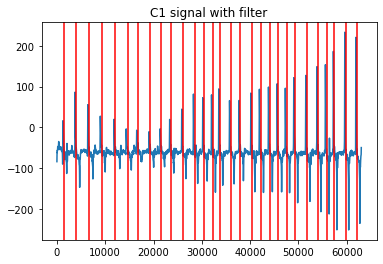

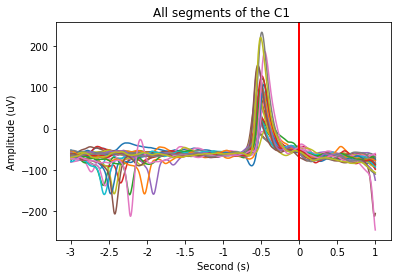

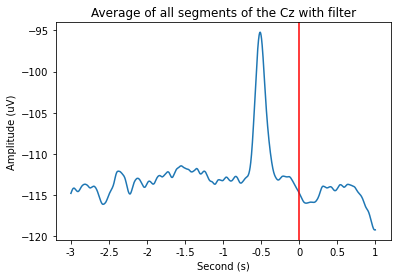

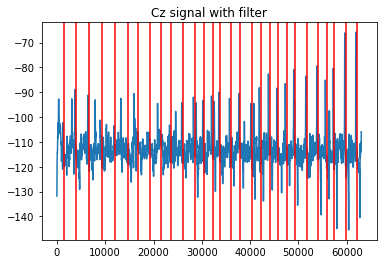

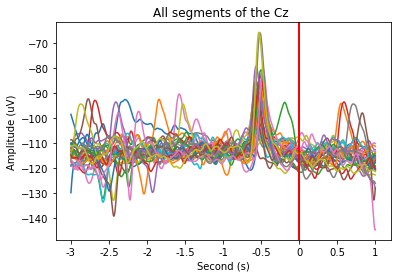

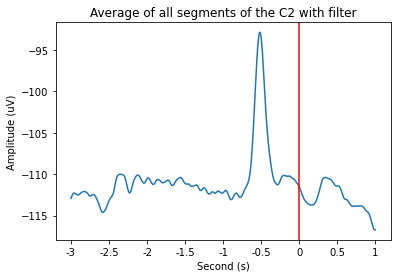

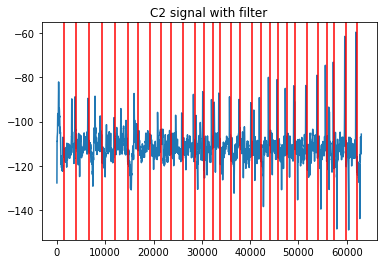

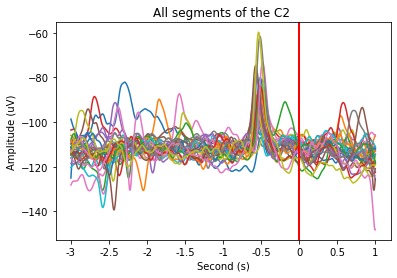

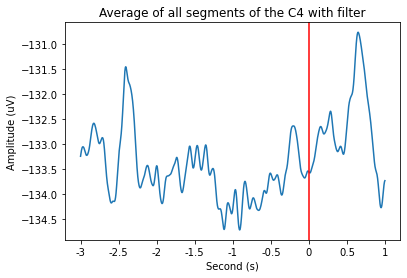

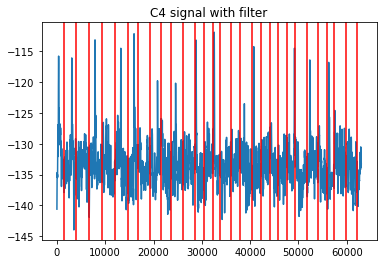

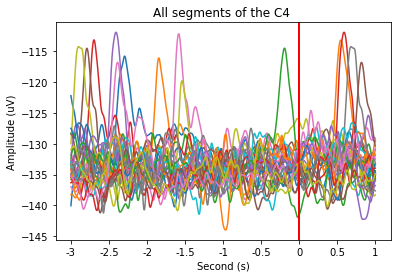

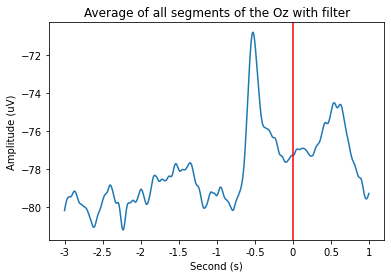

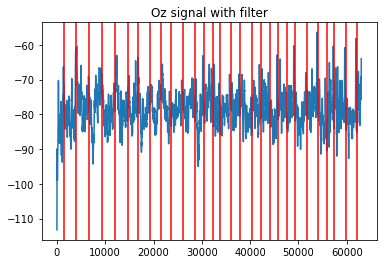

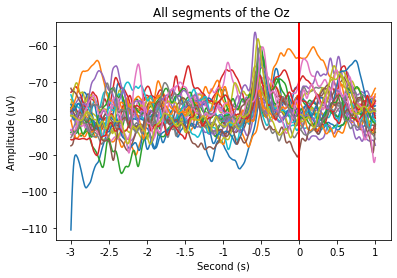

In [55]:
EEG_signal = [EEG_signals[0,:],EEG_signals[1,:],EEG_signals[2,:],EEG_signals[3,:],EEG_signals[4,:],EEG_signals[5,:]]
EEG_signal_name =['C3','C1','Cz','C2','C4','Oz']
for x,j in zip(EEG_signal, EEG_signal_name):
    b, a = scipy.signal.butter(2, 0.035)
    Signal = scipy.signal.filtfilt(b, a, x)*1000000
    
    
    
    exracted_data =[]
    
    movement_time_in_edf=[]
    for i in range(len(c)):
        starting_point = c[i]
        corresponding_time_stamp = unixfile[starting_point]
        
        firstEEGtimestamp = 1614156547000.0
        
        movement_time_in_edf1 = int(abs(firstEEGtimestamp-corresponding_time_stamp)/2)
        if movement_time_in_edf1 > len(EEG_signals[0,:]) :
            pass
        
        else:
            movement_time_in_edf.append(movement_time_in_edf1)
                
    movement_time_in_edf = np.array(movement_time_in_edf)
    
    for k in range(len(movement_time_in_edf)):
        extracted_dataa = Signal[int(movement_time_in_edf[k]-1500):int(movement_time_in_edf[k]+500)]
        exracted_data.append(extracted_dataa)
        

    plt.show()       
    exracted_data = np.array(exracted_data)
    

    average = np.mean(exracted_data, axis =0)
    fig, ax = plt.subplots()
    plt.plot(average)
    plt.axvline(x=1500, c ='r')
    ax.set_title('Average of all segments of the {} with filter'.format(j))
    
    positions = (np.arange(0,2001,250))
    labels = [-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1]
    plt.xticks(positions, labels)
    plt.xlabel('Second (s)',loc='center')
    plt.ylabel('Amplitude (uV)',loc='center')
    plt.savefig('Average of all segments of the {} with filter'.format(j))
   
    #mplcursors.cursor()
    plt.show()
    
    
    
    fig, ax = plt.subplots()
    plt.plot(Signal)
    ax.set_title('{} signal with filter'.format(j))
    plt.savefig('{} signal with filter'.format(j))
    #mplcursors.cursor()
    
    for xc in movement_time_in_edf:
        plt.axvline(x=xc, c ='r')
    
    plt.show()





    fig, ax = plt.subplots()
    for i in exracted_data:
        
        plt.plot(i)
        plt.axvline(x=1500, c ='r')
        ax.set_title('All segments of the {} '.format(j))
               
        positions = (np.arange(0,2001,250))
        labels = [-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1]
        plt.xticks(positions, labels)
        plt.xlabel('Second (s)',loc='center')
        plt.ylabel('Amplitude (uV)',loc='center')
        plt.savefig('All segments of the {} '.format(j)) 
        # ax.invert_yaxis()
       # mplcursors.cursor()
    plt.show()